## Modeling scATAC-seq using sequence features and a custom kNN graph

In this tutorial we demonstrate the applicability of mubind in a case where an arbitrarily complex graph is provided.
The dataset is mouse pancreatic endocrinogenesis multiome [Klein et al 2023]


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import seaborn

In [3]:
cd ~/workspace/theislab/mubind/docs/notebooks/single_cell

/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell


/home/ilibarra/miniconda3/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/ilibarra/miniconda3/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
import pandas as pd
import numpy as np
import os
import torch
import itertools
import glob
import pandas as pd
from pathlib import Path
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'
import torch
import mubind as mb
from tqdm.notebook import tqdm_notebook as tqdm

In [5]:
# pwms = mb.datasets.cisbp_hs()
pwms = mb.datasets.archetypes()
# pwms = pwms[:20]
len(pwms)

# motifs loaded 2179


286

In [6]:
import random
# reduced_groups = [p.to_numpy() for p in random.sample(pwms, 20) if p.shape[-1] != 0]

In [7]:

# suppress numba deprecations warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [8]:

import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
# mb.models.Mubind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

# device = 'cpu'

Using device: cuda:0


In [9]:
import scanpy as sc

In [10]:
# load the pancreas multiome dataset
rna, atac = mb.datasets.pancreas_multiome() # data_directory='../../../annotations/scatac')
rna.shape, atac.shape

True data/scatac/pancreas_multiome/pancreas_multiome_2022_processed_rna_velocities_2024.h5ad
True data/scatac/pancreas_multiome/pancreas_multiome_2022_processed_atac.h5ad


((16918, 14663), (16918, 228259))

In [11]:
# if rapids is available, use it
# import rapids_singlecell as rapids
# rapids.pp.neighbors(rna)

# if rapids is not avaible, default scanpy
sc.pp.neighbors(rna)


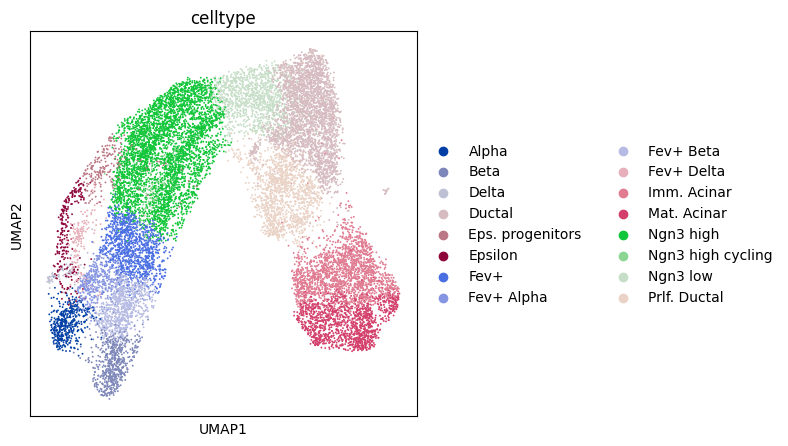

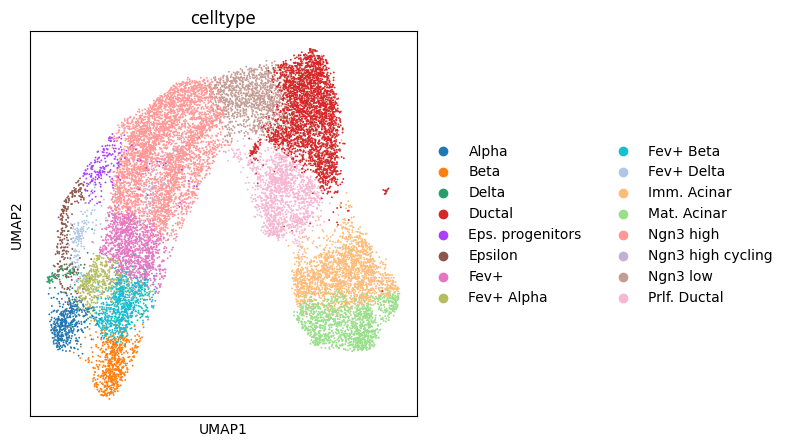

In [12]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 5, 5

# RNA
sc.pl.umap(rna, color='celltype')

#ATAC
sc.pl.umap(atac, color='celltype')

In [13]:
atac.obs_names

Index(['AAACAGCCAACAGCCT-1-0', 'AAACAGCCAACCCTCC-1-0', 'AAACAGCCACCTGTAA-1-0',
       'AAACAGCCACTAAGCC-1-0', 'AAACAGCCAGGATAAC-1-0', 'AAACAGCCATAAAGCA-1-0',
       'AAACATGCAAGGTAAC-1-0', 'AAACATGCAAGGTGGC-1-0', 'AAACATGCACTAGGTC-1-0',
       'AAACATGCAGCATTAT-1-0',
       ...
       'TTTGTGTTCACGAATC-1-1', 'TTTGTGTTCGAGCTAT-1-1', 'TTTGTGTTCGATCAGT-1-1',
       'TTTGTGTTCGCTATGG-1-1', 'TTTGTGTTCTCAATGA-1-1', 'TTTGTGTTCTTGTTCG-1-1',
       'TTTGTTGGTATTGAGT-1-1', 'TTTGTTGGTCCTAAGA-1-1', 'TTTGTTGGTTAACAGT-1-1',
       'TTTGTTGGTTGTTGCT-1-1'],
      dtype='object', length=16918)

In [14]:
# to match the barcode IDs, use the prefix from RNA to match ATAC (anchor = 10 first nucleotides)
assert np.all(rna.obs_names.str[:10] == atac.obs_names.str[:10])
rna.obs_names = atac.obs_names
rna.obs_names

Index(['AAACAGCCAACAGCCT-1-0', 'AAACAGCCAACCCTCC-1-0', 'AAACAGCCACCTGTAA-1-0',
       'AAACAGCCACTAAGCC-1-0', 'AAACAGCCAGGATAAC-1-0', 'AAACAGCCATAAAGCA-1-0',
       'AAACATGCAAGGTAAC-1-0', 'AAACATGCAAGGTGGC-1-0', 'AAACATGCACTAGGTC-1-0',
       'AAACATGCAGCATTAT-1-0',
       ...
       'TTTGTGTTCACGAATC-1-1', 'TTTGTGTTCGAGCTAT-1-1', 'TTTGTGTTCGATCAGT-1-1',
       'TTTGTGTTCGCTATGG-1-1', 'TTTGTGTTCTCAATGA-1-1', 'TTTGTGTTCTTGTTCG-1-1',
       'TTTGTTGGTATTGAGT-1-1', 'TTTGTTGGTCCTAAGA-1-1', 'TTTGTTGGTTAACAGT-1-1',
       'TTTGTTGGTTGTTGCT-1-1'],
      dtype='object', length=16918)

(array([  782.,   732.,   754.,   730.,   746.,   679.,   702.,   737.,
          666.,   657.,   638.,   621.,   587.,   636.,   639.,   640.,
          699.,   756.,   778.,   850.,   944.,  1070.,  1290.,  1566.,
         1888.,  2262.,  2990.,  3753.,  5173.,  6968., 10067., 15120.,
        26728., 62772., 71639.]),
 array([0.        , 0.01427051, 0.02854103, 0.04281154, 0.05708206,
        0.07135257, 0.08562309, 0.0998936 , 0.11416412, 0.12843463,
        0.14270515, 0.15697566, 0.17124618, 0.18551669, 0.19978721,
        0.21405772, 0.22832824, 0.24259875, 0.25686927, 0.27113978,
        0.2854103 , 0.29968081, 0.31395133, 0.32822184, 0.34249236,
        0.35676287, 0.37103339, 0.3853039 , 0.39957442, 0.41384493,
        0.42811545, 0.44238596, 0.45665648, 0.47092699, 0.48519751,
        0.49946802]),
 <BarContainer object of 35 artists>)

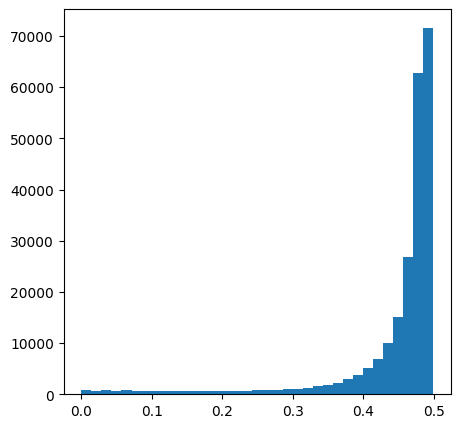

In [15]:
acc = (atac.X != 0).sum(axis=0) / atac.shape[0]
acc_score = abs(.5 - acc)
atac.var['acc_score'] = acc_score.A.T
atac.var['acc_score_rank'] = atac.var['acc_score'].rank(ascending=False)
plt.hist(atac.var['acc_score'], bins=35)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]


In [16]:
atac.shape

(16918, 228259)

In [17]:
n_select = 4000
n_sample_cells = n_select
# n_sample_peaks = 250
n_sample_peaks = int(n_sample_cells * 1.0)

n_cell_types = len(set(atac.obs['celltype']))

obs_sample = atac.obs.groupby('celltype').sample(int(n_sample_cells / n_cell_types), random_state=n_sample_cells, replace=True).index.drop_duplicates()
var_sample = pd.Series(atac.var_names).sample(n_sample_peaks, random_state=n_sample_peaks)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]

ad = atac[atac.obs_names.isin(obs_sample),atac.var_names.isin(var_sample)].copy()
ad.shape

(3051, 4000)

In [18]:
ad.obs['celltype'].value_counts()

celltype
Ductal               238
Ngn3 high            238
Imm. Acinar          236
Fev+                 232
Ngn3 low             231
Mat. Acinar          227
Prlf. Ductal         227
Fev+ Beta            214
Beta                 202
Alpha                197
Fev+ Alpha           190
Epsilon              156
Eps. progenitors     143
Fev+ Delta           130
Ngn3 high cycling    115
Delta                 75
Name: count, dtype: int64

In [19]:

# ad.uns['velocity_graph'] = rna_sample.uns['velocity_graph']
# # ad.layers['velocity'] = rna_sample.layers['velocity']
# ad.uns['velocity_graph'].shape



In [20]:

rna_sample = rna[ad.obs_names]

mask = rna.obs_names.isin(rna_sample.obs_names)

# local one step transposition to finalize processing
vgraph = rna.uns['velocity_graph']
vgraph = vgraph[mask == 1]
vgraph = vgraph.T
vgraph = vgraph[mask == 1]
vgraph = vgraph.T
vgraph.shape

(3051, 3051)

In [21]:
# the scvelo package is a condition to explore the vector stream visualization. Not priority
import scvelo as scv

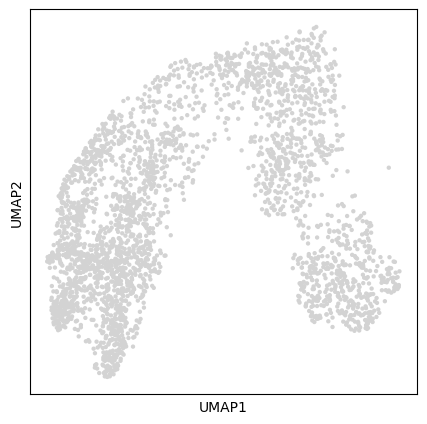

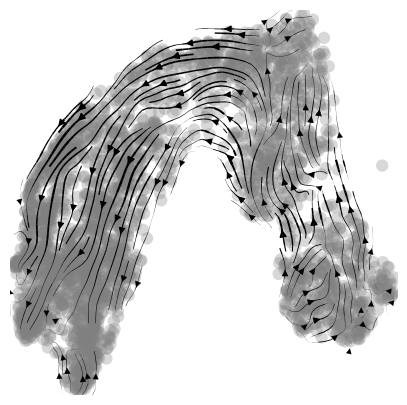

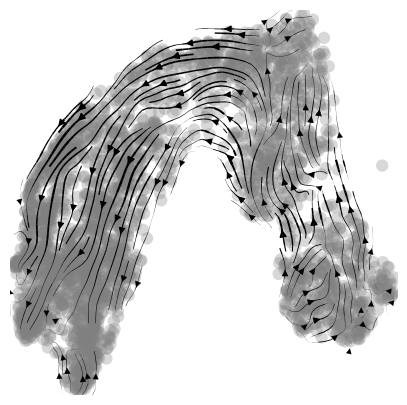

In [22]:

rna_sample.uns['velocity_graph'] = vgraph
try:
# atac
    sc.pl.umap(ad)

    # rna
    # append the estimated velocities to the sample adata
    scv.pl.velocity_embedding_stream(rna_sample)

    scv.pl.velocity_embedding_stream(rna_sample)
    rna_sample.shape
except Exception:
    print('sample too small to plot graph')


In [23]:
ad.var['chr'] = 'chr' + ad.var_names.str.split('-').str[0]
ad.var['start'] = ad.var_names.str.split('-').str[1].astype(int)
ad.var['end'] = ad.var_names.str.split('-').str[2].astype(int)

print('features by chromosome')
extend = 50
ad.var['chr'].value_counts()

features by chromosome


chr
chr2     293
chr1     282
chr5     273
chr11    258
chr7     237
chr8     236
chr6     234
chr4     232
chr9     223
chr3     216
chr13    188
chr10    188
chr17    168
chr12    163
chr15    158
chr16    145
chr14    144
chr18    136
chr19    134
chrX      91
chrY       1
Name: count, dtype: int64

In [24]:
ad.var['summit'] = ((ad.var['end'] + ad.var['start']) / 2).astype(int)
ad.var['summit.start'] = ad.var['summit'] - extend
ad.var['summit.end'] = ad.var['summit'] + extend
ad.var['k.summit'] = ad.var['chr'] + ':' + ad.var['summit.start'].astype(str) + '-' + ad.var['summit.end'].astype(str)

In [25]:
n_seqs = 10000 # adata.shape[1] # None # 1000
seqs = mb.bindome.tl.get_sequences_from_bed(ad.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='mm10', uppercase=True,
                                            gen_path='annotations/mm10/genome/mm10.fa',
                                            bin='/home/ilibarra/miniconda3/envs/mubind/bin/bedtools')
                                            # bin='/home/ilibarra/.conda/envs/mubind/bin/bedtools')
                                            # gen_path='../../../annotations/hg38/genome/hg38.fa')

keys = set([s[0] for s in seqs])
ad = ad[:,ad.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]
len(seqs)

/tmp/tmps1p853kx
genome mm10 True
annotations/mm10/genome/mm10.fa
True annotations/mm10/genome/mm10.fa
running bedtools...
['/home/ilibarra/miniconda3/envs/mubind/bin/bedtools', 'getfasta', '-fi', 'annotations/mm10/genome/mm10.fa', '-bed', '/tmp/tmps1p853kx', '-fo', '/tmp/tmp_zneeyse']
/home/ilibarra/miniconda3/envs/mubind/bin/bedtools getfasta -fi annotations/mm10/genome/mm10.fa -bed /tmp/tmps1p853kx -fo /tmp/tmp_zneeyse


4000

In [26]:
len(seqs)

4000

In [27]:
# remove Ns
for s in seqs:
    if 'N' in s:
        assert False
    # seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = ad.X.T

In [28]:
counts.shape

(4000, 3051)

In [29]:
next_data = pd.DataFrame(counts.A) # sparse.from_spmatrix(counts.A)

In [30]:
next_data['var'] = next_data.var(axis=1)
# next_data = next_data[range(100)].copy()

In [31]:
next_data.index = [s[1] for s in seqs]
next_data.index.name = 'seq'
next_data.shape

(4000, 3052)

In [32]:
next_data = next_data[~next_data.index.str.contains('N')]
next_data.shape

(4000, 3052)

In [33]:
# sum_index = next_data[next_data.columns[:-1]].var(axis=1).sort_values(ascending=False).index

In [34]:
n_cells = 10000
top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_cells]

In [35]:
# next_data.index

In [36]:
# next_data = next_data.head(10000)
next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)

In [37]:
del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']

In [38]:
df = next_data_sel.copy() # sample
# df = df[df.columns[:5000]] # .head(100) # sample

# shorten sequences/remove duplicates
# df.index = df.index.astype(str).str[35:-35]
# df = df[~df.index.duplicated(keep='first')]

zero_counts = df.sum(axis=1) == 0
df = df[~zero_counts] # remove zeroes

df.shape

(4000, 3051)

In [39]:
ad.shape, df.shape

((3051, 4000), (4000, 3051))

In [40]:
ad = ad[:,~zero_counts].copy()


In [41]:
df2 = df.reset_index().melt('seq').set_index('seq')
# add a baseline count
df2[0] = 1.0
cols = ['batch', 1, 0]
df2.columns = cols
df2 = df2[[0, 1, 'batch']] # cols[::-1]]
df2['batch'] = df2['batch'].astype(int)
print(df2.shape)
print(len(set(df2['batch'])))
n_cells = 200
df2 = df2[df2['batch'].isin(range(0, n_cells))]
print(df2['batch'].value_counts())
df2.head()

(12204000, 3)
3051
batch
0      4000
137    4000
127    4000
128    4000
129    4000
       ... 
69     4000
70     4000
71     4000
72     4000
199    4000
Name: count, Length: 200, dtype: int64


,0,1,batch
seq,,,
CTTTGCTGGGCTCTGTTCGACGTCCCACCTTCTCTTCCTCCACCCCCCCCTCACTCCTTTGCGTCCCGCCCCGCCTCCCCTCCCCCACTCTGCGGGCAAA,1.0,1.0,0
CAGAGTCAGCCGCTAGTGGGCGAGGCAAGCCCGCCCCAGGCCCCGCCCAGAGCGCCCTTGTTTTCTTACAAACTCGCAACAGAGTAGCGAGAGCCACTTT,1.0,3.0,0
GAAAATACAGTCTGGCCAACCCACCGGCGGCCGCCGCCGCCGCCGCTCCAGTTCGCGCCCGGCTGTTCCGCCCCTCCGCCCGCTCAGCGGAGACTAGAGA,1.0,0.0,0
CCATGCTGGCGGGGCTGGGGCCGGGACAGAGCCCGTGGCGGGGCGGCCTGTGGTCCGGCGATCTCAGGCTGAGCGCCAGGCCCCAGCGCCGCTCTTTCGG,1.0,2.0,0
GAGTCACGCGCCTTTCAGTTGGAAACTTGGCATGCAGAGGAGGACAGTGGCCCTCATCTCCCCGCCCACCTCCCGTGCCATTGGTGCGGCACGCCGACTG,1.0,1.0,0


### Simple motif enrichment

In [42]:
use_kmers = False
if use_kmers:
    kmers_by_module = {}
    pwm_by_module = {}
    glossary_kmers_dir = '../../../../../zaugglab/apobec2_data_analysis/src/analyses_2023_new_sample/Glossary Modules'
    for f in os.listdir(glossary_kmers_dir):
        if not f.endswith('.xlsx'):
            continue
        name = f.replace('Glossary_module_', '').replace('.xlsx', '')
        kmers = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='8mers')
        kmers_by_module[name] = kmers[kmers.columns[0]]
        pwm = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='PWM', index_col=0)
        pwm_by_module[name] = pwm

### Generate pos and neg

In [43]:
# import ushuffle

# fg = df.index
# bg = []

# for i, s in enumerate(fg):
#     # print(i, s)
#     bg.append(ushuffle.shuffle(str.encode(s), 2))



In [44]:
# for a, b in zip(fg, bg):
#     # print(len(a[1]), len(b))
#     assert len(a) == len(b)

In [45]:
frac_acc = (df > 0).sum(axis=0) / df.shape[1]

In [46]:
reduced_groups = pwms

In [47]:
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
n_batch = len(set(dataset.batch))
n_kernels = len(pwms)
train = tdata.DataLoader(dataset=dataset, batch_size=128, shuffle=True)


In [48]:
# df_neg = df.copy()
# df_neg.index = bg
# df_neg.index = df_neg.index.astype(str)

# dataset_neg = mb.datasets.SelexDataset(df_neg, n_rounds=df_neg.shape[1], enr_series=False)
# train_neg = tdata.DataLoader(dataset=dataset_neg, batch_size=512, shuffle=True)


### The parameter log_dynamic defines whether a kNN-graph will be used

In [49]:
len(pwms)

286

In [50]:
# for unit tests
# torch.save(train, '../../../tests/_data/pancreas_multiome.pth')
# ad.write('../../../tests/_data/pancreas_multiome.h5ad', compression='lzf')

In [51]:
rna_sample.shape, ad.shape

((3051, 14663), (3051, 4000))

In [52]:
criterion = mb.tl.PoissonLoss()
w = [r.shape[1] for r in pwms]
optimize_log_dynamic = True
model = mb.models.Mubind.make_model(train, n_kernels, criterion, kernels=[0, 2,] + w, # [0, 2] + w,
                                        # use_dinuc=True, dinuc_mode='full',
                                        optimize_sym_weight=False,
                                        optimize_exp_barrier=True,
                                        optimize_prob_act=True,
                                        optimize_log_dynamic=optimize_log_dynamic,
                                        use_dinuc=False,
                                        device=device,
                                        p_dropout=0.8,
                                        prepare_knn=optimize_log_dynamic,
                                        velocity_graph=vgraph,
                                        knn_free_weights=False,
                                        adata=None if not optimize_log_dynamic else ad,
                                        dinuc_mode=None)
print('no err')

(3051, 3051)
setting up log dynamic
no err


In [53]:
# model.graph_module.conn_sparse.shape

setting up log dynamic
True
12
order None
0 out of 288...
break


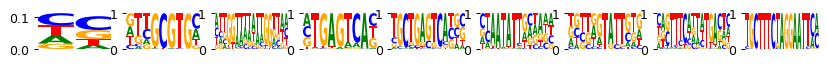

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [11:48<00:00, 47.25s/it]


Current time: 2024-06-10 02:37:23.233883
	Loss: 158.599 , R2: 0.304
	Training time (model/function): (708.867s / 708.867s)
		per epoch (model/function): (50.633s/ 50.633s)
		per 1k samples: 12.658s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995060360864985, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 70

### next filter to optimize 70 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [12:03<00:00, 48.23s/it]


Current time: 2024-06-10 02:49:28.905690
	Loss: 149.305 , R2: 0.304
	Training time (model/function): (1432.401s / 723.534s)
		per epoch (model/function): (102.314s/ 51.681s)
		per 1k samples: 12.920s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995060360864985, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [11:39<00:00, 46.66s/it]


Current time: 2024-06-10 03:01:10.930502
	Loss: 144.706 , R2: 0.304
	Training time (model/function): (2132.382s / 699.981s)
		per epoch (model/function): (152.313s/ 49.999s)
		per 1k samples: 12.500s
best loss 144.706
last five r2 values, by sequential filter optimization: ['0.304']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995060360864985, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 140

### next filter to optimize 140 

FREEZING KERNELS
optimizing feature type mono
next kernels {140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209}
filters mask None
optimizer:  Adam , criterion: Poisson

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [11:46<00:00, 47.11s/it]


Current time: 2024-06-10 03:13:01.746604
	Loss: 148.415 , R2: 0.304
	Training time (model/function): (2839.148s / 706.767s)
		per epoch (model/function): (202.796s/ 50.483s)
		per 1k samples: 12.621s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995060360864985, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [11:55<00:00, 47.67s/it]


Current time: 2024-06-10 03:24:58.953632
	Loss: 144.630 , R2: 0.304
	Training time (model/function): (3554.326s / 715.177s)
		per epoch (model/function): (253.880s/ 51.084s)
		per 1k samples: 12.771s
best loss 144.627
last five r2 values, by sequential filter optimization: ['0.304', '0.304']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995060360864985, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 210

### next filter to optimize 210 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [09:32<00:00, 38.19s/it]


Current time: 2024-06-10 03:34:35.817621
	Loss: 148.409 , R2: 0.304
	Training time (model/function): (4127.332s / 573.006s)
		per epoch (model/function): (294.809s/ 40.929s)
		per 1k samples: 10.232s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995060360864985, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [11:32<00:00, 46.16s/it]


Current time: 2024-06-10 03:46:10.399680
	Loss: 144.627 , R2: 0.304
	Training time (model/function): (4819.939s / 692.608s)
		per epoch (model/function): (344.281s/ 49.472s)
		per 1k samples: 12.368s
best loss 144.626
last five r2 values, by sequential filter optimization: ['0.304', '0.304', '0.304']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995060360864985, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 280

### next filter to optimize 280 

FREEZING KERNELS
optimizing feature type mono
next kernels {280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349}
filters mask None
optimizer:  Adam , 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [11:17<00:00, 45.15s/it]


Current time: 2024-06-10 03:57:31.606370
	Loss: 148.407 , R2: 0.304
	Training time (model/function): (5497.348s / 677.409s)
		per epoch (model/function): (392.668s/ 48.386s)
		per 1k samples: 12.097s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995060360864985, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [11:40<00:00, 46.71s/it]


Current time: 2024-06-10 04:09:14.361252
	Loss: 144.626 , R2: 0.304
	Training time (model/function): (6198.140s / 700.792s)
		per epoch (model/function): (442.724s/ 50.057s)
		per 1k samples: 12.514s
best loss 144.625
last five r2 values, by sequential filter optimization: ['0.304', '0.304', '0.304', '0.304']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995060360864985, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 6198.1403975486755s
Time per epoch (total): 1.435 s
True
12
order None
0 out of 288...
break


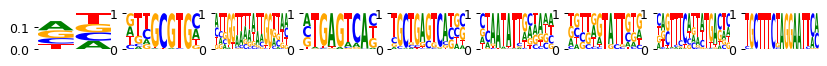

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:16<00:00,  1.09s/it]


Current time: 2024-06-10 04:09:35.938727
	Loss: 158.595 , R2: 0.305
	Training time (model/function): (16.547s / 16.547s)
		per epoch (model/function): (1.182s/ 1.182s)
		per 1k samples: 0.295s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991513768692604, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 70

### next filter to optimize 70 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:16<00:00,  1.09s/it]


Current time: 2024-06-10 04:09:54.442318
	Loss: 149.303 , R2: 0.305
	Training time (model/function): (33.111s / 16.564s)
		per epoch (model/function): (2.365s/ 1.183s)
		per 1k samples: 0.296s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991513768692604, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:16<00:00,  1.08s/it]


Current time: 2024-06-10 04:10:12.615171
	Loss: 144.705 , R2: 0.305
	Training time (model/function): (49.374s / 16.263s)
		per epoch (model/function): (3.527s/ 1.162s)
		per 1k samples: 0.290s
best loss 144.705
last five r2 values, by sequential filter optimization: ['0.304']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991513768692604, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 140

### next filter to optimize 140 

FREEZING KERNELS
optimizing feature type mono
next kernels {140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
e

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:16<00:00,  1.10s/it]


Current time: 2024-06-10 04:10:33.157573
	Loss: 148.421 , R2: 0.306
	Training time (model/function): (66.064s / 16.689s)
		per epoch (model/function): (4.719s/ 1.192s)
		per 1k samples: 0.298s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991513768692604, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:15<00:00,  1.03s/it]


Current time: 2024-06-10 04:10:50.582148
	Loss: 144.629 , R2: 0.306
	Training time (model/function): (81.698s / 15.634s)
		per epoch (model/function): (5.836s/ 1.117s)
		per 1k samples: 0.279s
best loss 144.626
last five r2 values, by sequential filter optimization: ['0.304', '0.305']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991513768692604, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 210

### next filter to optimize 210 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion: Poiss

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:16<00:00,  1.09s/it]


Current time: 2024-06-10 04:11:10.877994
	Loss: 148.424 , R2: 0.306
	Training time (model/function): (98.226s / 16.528s)
		per epoch (model/function): (7.016s/ 1.181s)
		per 1k samples: 0.295s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991513768692604, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:15<00:00,  1.03s/it]


Current time: 2024-06-10 04:11:28.387158
	Loss: 144.627 , R2: 0.305
	Training time (model/function): (113.797s / 15.571s)
		per epoch (model/function): (8.128s/ 1.112s)
		per 1k samples: 0.278s
best loss 144.626
last five r2 values, by sequential filter optimization: ['0.304', '0.305', '0.305']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991513768692604, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 280

### next filter to optimize 280 

FREEZING KERNELS
optimizing feature type mono
next kernels {280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349}
filters mask None
optimizer:  Adam , criter

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:16<00:00,  1.10s/it]


Current time: 2024-06-10 04:11:48.917909
	Loss: 148.442 , R2: 0.305
	Training time (model/function): (130.394s / 16.597s)
		per epoch (model/function): (9.314s/ 1.186s)
		per 1k samples: 0.296s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991513768692604, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:15<00:00,  1.02s/it]


Current time: 2024-06-10 04:12:06.287345
	Loss: 144.627 , R2: 0.305
	Training time (model/function): (145.894s / 15.500s)
		per epoch (model/function): (10.421s/ 1.107s)
		per 1k samples: 0.277s
best loss 144.626
last five r2 values, by sequential filter optimization: ['0.304', '0.305', '0.305', '0.305']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9991513768692604, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 145.8936369419098s
Time per epoch (total): 0.034 s


In [54]:
import torch.optim as topti
import warnings

model_by_logdynamic = {}
n_epochs_intercept = 15
n_epochs_kernel = 15
log_each=75
n_unfreeze_kernels=70


for optimize_log_dynamic in [True, False]:
    warnings.filterwarnings("ignore")

    criterion = mb.tl.PoissonLoss()
    w = [r.shape[1] for r in pwms]
    model = mb.models.Mubind.make_model(train, n_kernels, criterion, kernels=[0, 2,] + w, # [0, 2] + w,
                                           # use_dinuc=True, dinuc_mode='full',
                                           optimize_sym_weight=False,
                                           optimize_exp_barrier=True,
                                           optimize_prob_act=True,
                                           optimize_log_dynamic=optimize_log_dynamic,
                                           use_dinuc=False,
                                           device=device,
                                           p_dropout=0.8,
                                           prepare_knn=optimize_log_dynamic,
                                           knn_free_weights=False,
                                           adata=None if not optimize_log_dynamic else ad,
                                           dinuc_mode=None) # .cuda()

    # initialize the reduce kernels
    for i, mono_best in enumerate(pwms):
        mono_best = mono_best.to_numpy()
        if mono_best.shape[-1] == 0:
            continue
        # print(mono_best.shape, model.binding_modes.conv_mono[i + 1].weight.shape)
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
        new_w = mono_best.reshape([1, 1] + list(mono_best.shape))
        # print(i, i + 1)
        model.binding_modes.conv_mono[i + 2].weight = torch.nn.Parameter(torch.tensor(new_w, dtype=torch.float))
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
    # move the model a final time to the GPU
    model = model.to(device)

    mb.pl.set_rcParams({'figure.figsize': [15, 3], 'figure.dpi': 90})
    mb.pl.logo(model,
               title=False,
               xticks=False,
               rowspan_dinuc=0,
               rowspan_mono=1,
               n_rows=5,
               n_cols=12,
               stop_at=10   ) # n_cols=len(reduced_groups))

    mb.pl.set_rcParams({'figure.figsize': [20, 5], 'figure.dpi': 100})

    # mb.pl.conv(model, n_cols=2)
    import torch.nn as tnn

    model, best_loss = model.optimize_iterative(train,
                                                n_epochs=[n_epochs_intercept] + [n_epochs_kernel] * (n_kernels + 1),
                                                show_logo=False,
                                                use_mono=True, use_dinuc=False, dinuc_mode='local',
                                                opt_kernel_shift=[0, 0] + [0] * (n_kernels),
                                                opt_kernel_length=[0, 0] + [0] * (n_kernels),
                                                opt_one_step=True,
                                                shift_max=1, shift_step=1,
                                                # optimiser=topti.SGD,
                                                optimiser=topti.Adam,
                                                n_unfreeze_kernels=n_unfreeze_kernels,
                                                # skip_kernels=list(range(1, 2)) + list(range(5, 500)),
                                                n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                                kernels = [0] + [2] + [20] * (n_kernels), r2_per_epoch=True,
                                                exp_max=8,
                                                early_stopping=250, log_each=log_each, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

    model_by_logdynamic[optimize_log_dynamic] = model

In [55]:
pwd

'/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell'

In [56]:
print('here...')

here...


Text(0.5, 0, 'learned etas (per sample)')

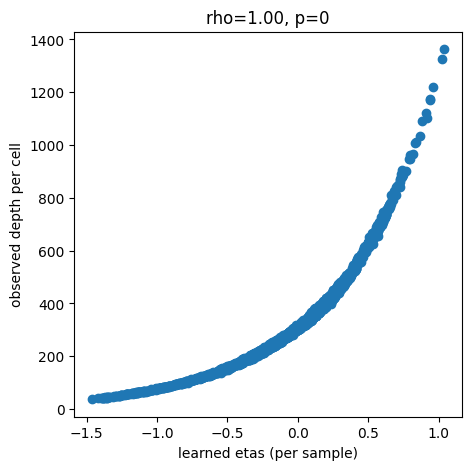

In [57]:
## correlation between etas and observed counts per cell
rcParams['figure.figsize'] = 5, 5
etas = model.get_log_etas()
lib_sizes = train.dataset.rounds.sum(axis=0)
etas.shape, lib_sizes.shape
from scipy.stats import spearmanr

a = etas.detach().cpu().flatten()
b = lib_sizes.flatten()
plt.scatter(a, b)
plt.title('rho=%.2f, p=%.2g' % spearmanr(a, b))
plt.ylabel('observed depth per cell')
plt.xlabel('learned etas (per sample)')

In [58]:
save_output = False

if save_output:
    for use_logdynamic in [False, True]:
        p = 'pancreas_multiome_use_logdynamic_%i.pth' % use_logdynamic
        print(p)
        torch.save(model_by_logdynamic[use_logdynamic], p)

    ad.write('atac_train.h5ad')
    rna_sample.write('rna_sample_train.h5ad')

    import pickle
    pickle.dump(train, open('train_dataloader.pkl', 'wb'))

: 